In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import math

In [3]:
class MLP(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )

    def forward(self, xb):
        return xb + self.mlp(xb)

In [4]:
class AttentionHead(nn.Module):
    def __init__(self, d_head, bias=True, mask=True):
        super().__init__()
        self.d_head = d_head
        self.add_mask = mask
        self.Q = nn.Linear(d_head, d_head, bias=bias)
        self.K = nn.Linear(d_head, d_head, bias=bias)
        self.V = nn.Linear(d_head, d_head, bias=bias)

    def forward(self, xb):
        q = self.Q(xb)
        k = self.K(xb)
        v = self.V(xb)
        weights = torch.bmm(q, k.transpose(-1, -2)) / math.sqrt(self.d_head)
        attention = torch.softmax(weights, dim=-1)
        return torch.bmm(attention, v)

In [5]:
class AttentionLayer(nn.Module):
    def __init__(self, d_model, n_heads, bias=True, mask=True):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_head = d_model // n_heads
        self.heads = [AttentionHead(self.d_head, bias=bias, mask=mask) for _ in range(n_heads)]
        self.O = nn.Linear(d_model, d_model, bias=bias)

    def forward(self, xb):
        outputs = []
        for i, head in enumerate(self.heads):
            input = xb[..., i*self.d_head : (i+1)*self.d_head]
            outputs.append(head(input))
        return xb + self.O(torch.cat(outputs, dim=-1))

In [6]:
class ModAddition(nn.Module):
    def __init__(self, prime, d_model, n_heads, bias=True, mask=True):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Linear(prime, d_model, bias=bias),
            AttentionLayer(d_model, n_heads, bias=bias, mask=mask),
            MLP(d_model),
            nn.Linear(d_model, prime, bias=bias)
        )

    def forward(self, xb):
        input = F.one_hot(xb, num_classes=113).float()
        return self.transformer(input)[:, 1, :]

In [7]:
prime = 113
lr = 1e-3
weight_decay = 1

model = ModAddition(prime, 128, 4, bias=False, mask=True)
loss_fn = F.cross_entropy

In [8]:
pairs = torch.tensor([[m, n] for m in range(prime) for n in range(prime)])
perm = torch.randperm(pairs.size(0))
shuffled_pairs = pairs[perm]

train_split = 0.3

x_train = shuffled_pairs[: int(train_split * pairs.size(0))]
x_valid = shuffled_pairs[int(train_split * pairs.size(0)) :]

y_train = x_train.sum(-1) % prime
y_valid = x_valid.sum(-1) % prime

In [9]:
train_loss = []
valid_loss = []
optim = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

def fit(model, loss_fn, optim, num_epochs, x_train, y_train, x_valid, y_valid):
    model.train()
    for epoch in range(num_epochs):
        pred = model(x_train)
        loss = loss_fn(pred, y_train)

        loss.backward()
        optim.step()
        optim.zero_grad()

        if epoch % 50 == 0:
            model.eval()
            
            train_loss.append(loss.item())
            v_loss = loss_fn(model(x_valid), y_valid)
            valid_loss.append(v_loss.item())

            print(f"Train loss at epoch {epoch}: {loss:.5f}")
            print(f"Valid loss as epoch {epoch}: {v_loss:.5f}")
            print("--------------------------------")

            model.train()

In [10]:
num_epochs = 6000
fit(model, loss_fn, optim, num_epochs, x_train, y_train, x_valid, y_valid)

Train loss at epoch 0: 4.72842
Valid loss as epoch 0: 4.72955
--------------------------------
Train loss at epoch 50: 4.26727
Valid loss as epoch 50: 5.38993
--------------------------------
Train loss at epoch 100: 3.22701
Valid loss as epoch 100: 7.74525
--------------------------------
Train loss at epoch 150: 1.00729
Valid loss as epoch 150: 12.86498
--------------------------------
Train loss at epoch 200: 0.06759
Valid loss as epoch 200: 18.43238
--------------------------------
Train loss at epoch 250: 0.03482
Valid loss as epoch 250: 18.57335
--------------------------------
Train loss at epoch 300: 0.02918
Valid loss as epoch 300: 17.92387
--------------------------------
Train loss at epoch 350: 0.02572
Valid loss as epoch 350: 17.32144
--------------------------------
Train loss at epoch 400: 0.02303
Valid loss as epoch 400: 16.79077
--------------------------------
Train loss at epoch 450: 0.02079
Valid loss as epoch 450: 16.31220
--------------------------------
Train los

In [11]:
print((model(x_train).argmax(-1) == y_train).float().mean())
print((model(x_valid).argmax(-1) == y_valid).float().mean())

tensor(1.)
tensor(1.)


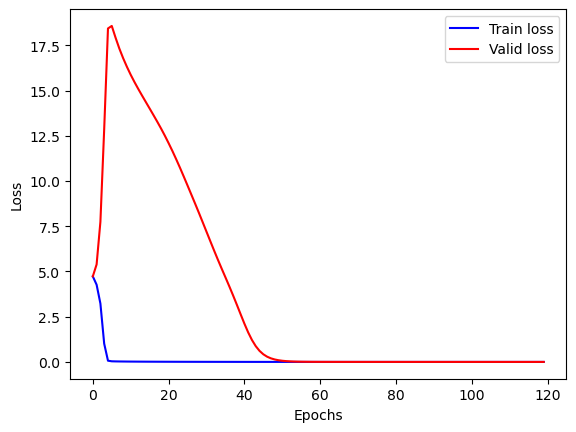

In [57]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(train_loss, color='b', label='Train loss')
plt.plot(valid_loss, color='r', label="Valid loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

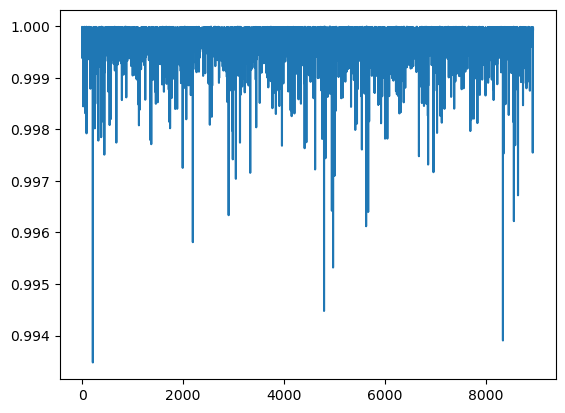

In [13]:
plt.clf()
pred = model(x_valid).detach()
prob = pred.softmax(-1)
plt.plot(prob.max(-1).values)